In [1]:
import time
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as trans
from PIL import Image
import torchvision.datasets as dsets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
label=pd.read_csv('dog-breed-identification/labelslist.csv',header=None)#加载标签类别号序列对
labelslist=label.values.tolist()[0]
label_dictionary=dict(zip(labelslist,range(120)))

trpiclabels=pd.read_csv('dog-breed-identification/labels.csv')#加载图片标签序列对
trpiclabels=dict(trpiclabels.values.tolist())

tenames=[]

In [3]:
def read_train_data():
    train_image_label=[]
    train_transform = trans.Compose([
        trans.ToPILImage(),
        trans.Resize((256, 256)),
        trans.RandomCrop((224, 224)), #训练集中的数据增强操作
        trans.ToTensor()
    ])
    path='dog-breed-identification/train'
    pic=os.listdir(path)#训练图片集
    
    for i in pic:
        name=i.split('.')
        pathpic=path+'/'+i
        img = Image.open(pathpic).convert('RGB')
        img_np = np.array(img)
        img_tensor=train_transform(img_np)
        l=label_dictionary[trpiclabels[name[0]]]
        train_image_label.append((img_tensor,l))
    return train_image_label

In [4]:
def read_test_data():
    test_image_label=[]
    train_transform = trans.Compose([
        trans.ToPILImage(),
        trans.Resize((224, 224)),
        trans.ToTensor()
    ])
    path='dog-breed-identification/test'
    pic=os.listdir(path)#测试图片集
    for i in pic:
        name=i.split('.')
        tenames.append(name[0])
        pathpic=path+'/'+i
        img = Image.open(pathpic).convert('RGB')
        img_np = np.array(img)
        img_tensor=train_transform(img_np)
        test_image_label.append(img_tensor)
    return test_image_label

In [5]:
train_set=read_train_data()
test_set=read_test_data()

train_dl = DataLoader(train_set, batch_size = 50, shuffle = True, drop_last = True)
test_dl = DataLoader(test_set, batch_size = 50, shuffle = False, drop_last = False)

In [6]:
print(len(tenames),tenames[0])#测试用

10357 000621fb3cbb32d8935728e48679680e


torch.Size([3, 224, 224]) 19


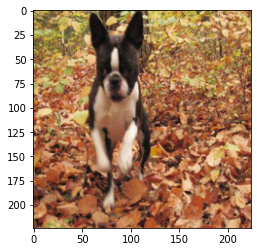

In [7]:
print(train_set[0][0].shape,train_set[0][1])#测试用
plt.imshow(train_set[0][0].detach().numpy().transpose([1,2,0]))

In [8]:
class myvgg(nn.Module):
    def __init__(self):
        super(myvgg,self).__init__()
        self.features=nn.Sequential(nn.Conv2d(3, 64, 3, 1, 1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(64, 64, 3, 1, 1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2, 2, 0, 1),
                                    nn.Conv2d(64, 128, 3, 1, 1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(128, 128, 3, 1, 1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2, 2, 0, 1),
                                    nn.Conv2d(128, 256, 3, 1, 1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(256, 256, 3, 1, 1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(256, 256, 3, 1, 1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2, 2, 0, 1),
                                    nn.Conv2d(256, 512, 3, 1, 1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 512, 3, 1, 1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 512, 3, 1, 1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2, 2, 0, 1),
                                    nn.Conv2d(512, 512, 3, 1, 1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 512, 3, 1, 1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 512, 3, 1, 1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2, 2, 0, 1)
                                   )
        self.avgpool=nn.AdaptiveAvgPool2d((7, 7))
        self.classifier=nn.Sequential(nn.Linear(25088, 4096),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.5),
                                      nn.Linear(4096, 4096),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.5),
                                      nn.Linear(4096, 120)
                                     )
        
    def forward(self,x):
        o=self.features(x)
        o=self.avgpool(o)
        o=o.view(-1,25088)
        o=self.classifier(o)
        return o

In [9]:
net=myvgg().to(device)
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [10]:
def eval(model,criterion,dataloader):
    net.eval()#因为使用了dropout，所以需要在评估时用这个函数让网络不再dropout
    loss = 0#预测偏差值
    accuracy = 0#预测准确率
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()
        probs,pred_y = logits.data.max(dim = 1)
        accuracy += (pred_y == batch_y.data).sum().double()/batch_y.size(0)
    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

In [11]:
nepochs = 30
for epoch in range(nepochs):
    net.train()#使dropout发挥作用
    for batch_x,batch_y in train_dl:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)#有平均
        error.backward()
        optimizer.step()
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    print('train error: %.1e, train acc: %.2f'%(tr_loss,tr_acc))

train error: 4.8e+00, train acc: 1.16
train error: 4.7e+00, train acc: 1.87
train error: 4.6e+00, train acc: 3.11
train error: 4.4e+00, train acc: 3.65
train error: 4.3e+00, train acc: 4.75
train error: 4.3e+00, train acc: 5.53
train error: 4.0e+00, train acc: 7.49
train error: 3.9e+00, train acc: 8.81
train error: 4.1e+00, train acc: 6.93
train error: 3.6e+00, train acc: 13.49
train error: 3.5e+00, train acc: 16.64
train error: 3.4e+00, train acc: 16.81
train error: 3.2e+00, train acc: 20.41
train error: 3.1e+00, train acc: 24.58
train error: 3.0e+00, train acc: 26.22
train error: 2.8e+00, train acc: 30.18
train error: 2.6e+00, train acc: 33.78
train error: 2.6e+00, train acc: 34.36
train error: 2.4e+00, train acc: 39.66
train error: 2.3e+00, train acc: 41.36
train error: 1.9e+00, train acc: 53.22
train error: 1.7e+00, train acc: 59.43
train error: 1.5e+00, train acc: 63.79
train error: 1.4e+00, train acc: 65.69
train error: 1.1e+00, train acc: 74.38
train error: 1.2e+00, train acc: 7

In [20]:
test_dl = DataLoader(test_set, batch_size = 50, shuffle = False, drop_last = False)

In [24]:
a=0
for i in test_dl:
    batch_x=batch_x.to(device)
    logits = net(batch_x)
    result1=nn.functional.softmax(logits)
    if a!=0:
        result=torch.cat([result,result1.detach()],dim=0)
    else:
        result=result1.detach()
        a+=1
result=result.to('cpu').numpy()

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/ipykernel/__main__.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [26]:
result=result[:-43,:]
#result1.shape
pd.DataFrame(result,tenames,labelslist).to_csv('submit.csv')

In [14]:
torch.save(net.state_dict(), 'vgg.pt')